# Studi Kasus 1 (Walkthrough)

<p> Pada kali ini Anda akan berperan sebagai seorang data engineer. Anda mendapatkan permintaan dari seorang *data analyst* dan *data scientist* untuk melakukan proses *data wrangling* pada sebuah dataset film untuk memastikan dataset tersebut siap dan layak untuk dianalisis oleh sang *data analyst* dan dapat menjadi basis pengembangan sebuah model prediktif yang sedang dikerjakan oleh sang *data scientist*</p>

<p>Dataset yang anda gunakan pada proyek ini berisi sejumlah daftar film beserta yang memuat informasi seperti:


*   Judul Film, *Content Rating*, *Genre*, Tahun Rilis, IMDb *Score*, Jumlah Vote IMDb,
*   Biaya Produksi (`budget`) dan Pemasukan Kotor (`gross`) yang dicetak masing-masing film
*   Flag yang merepresentasikan keterangan apakah film tersebut pernah dinominasikan/memenangkan kategori `*Best Picture*` pada *Academy Awards*.


Atas data tersebut, berikut detil informasi dan permintaan dari *data analyst*:
1.  Lakukan Penanganan Missing Values (Jika ada)
2.  Lakukan split atas kolom `released` sehingga didapatkan 2 kolom baru yakni `released_date` dan `released_country`. Lakukan penyesuaian format pada kolom `released_date` yang baru dibentuk sehingga memenuhi format **'yyyy-mm-dd'**
3.  Untuk setiap pemasukan kotor yang diperoleh masing-masing film, 50% di antaranya disetorkan ke Pihak Bioskop. Ini berarti Penghasilan yang diterima Pihak Studio hanya 50% dari total *gross*. Dengan informasi ini, hitunglah:
  * profit (50% gross - budget) yang dibukukan oleh masing-masing film.
  * Hitung pula profit yang telah disesuaikan berdasarkan tingkat inflasi pada tahun di mana masing-masing film tersebut dirilis!
4.   Kategorisasikan Profit (setelah disesuaikan dengan tingkat inflasi) ke dalam 5 kelas:
  * Rugi (Kurang dari 0)
  * 0 <= profit < 500,000
  * 500,000 <= profit < 1,000,000
  * 1,000,000 <= profit < 100,000,000
  * lebih dari 100,000,000

5.  Petakan kategori pada nomor 2 ke dalam list **[loss, low, medium, high, very high]**

Adapun permintaan dari *data scientist* adalah **lakukan transformasi atas seluruh *categorical attributes* yang ada ke dalam bentuk Encoding yang paling sesuai**




#0. Instalasi dan Import Library

In [1]:
!pip install -U pandera

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.


In [2]:
!pip install missingno

In [3]:
import pandas as pd
import numpy as np
import pandera as pa
import missingno as msno
from tqdm import tqdm
import warnings, re

warnings.filterwarnings("ignore")

#1. Discovery and Preliminary Cleaning (Handling Missing Values)

In [259]:
df = pd.read_csv("1. movies.csv")
display(df.head())

print("Jumlah Record: ", len(df))

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,NaN,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
1,Phobia,R,Drama,1980,"September 9, 1980 (United States)",4.0,NaN,John Huston,Gary Sherman,Paul Michael Glaser,Canada,5100000,NaN,Borough Park Productions,94.0,NaN
2,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6.1,NaN,Lamont Johnson,David Eyre,Scott Glenn,United States,5100000,NaN,Cattle Annie Productions,97.0,NaN
3,The Last Flight of Noah's Ark,G,Adventure,1980,"June 25, 1980 (United States)",5.8,1300.0,Charles Jarrott,Ernest K. Gann,Elliott Gould,United States,6000000,NaN,Walt Disney Productions,97.0,NaN
4,Oh Heavenly Dog,PG,Comedy,1980,"July 11, 1980 (United States)",5.4,2400.0,Joe Camp,Rod Browning,Chevy Chase,United States,6000000,NaN,Mulberry Square Productions,103.0,NaN


Jumlah Record:  5436


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5436 non-null   object 
 1   rating          5424 non-null   object 
 2   genre           5436 non-null   object 
 3   year            5436 non-null   int64  
 4   released        5436 non-null   object 
 5   score           5436 non-null   float64
 6   votes           5397 non-null   float64
 7   director        5436 non-null   object 
 8   writer          5436 non-null   object 
 9   star            5436 non-null   object 
 10  country         5435 non-null   object 
 11  budget          5436 non-null   int64  
 12  gross           5396 non-null   float64
 13  company         5434 non-null   object 
 14  runtime         5435 non-null   float64
 15  best_pic_award  208 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 679.6+ KB


##1.1 Check Missing Values

In [7]:
df.isna().sum()

name                 0
rating              12
genre                0
year                 0
released             0
score                0
votes               39
director             0
writer               0
star                 0
country              1
budget               0
gross               40
company              2
runtime              1
best_pic_award    5228
dtype: int64

<Axes: >

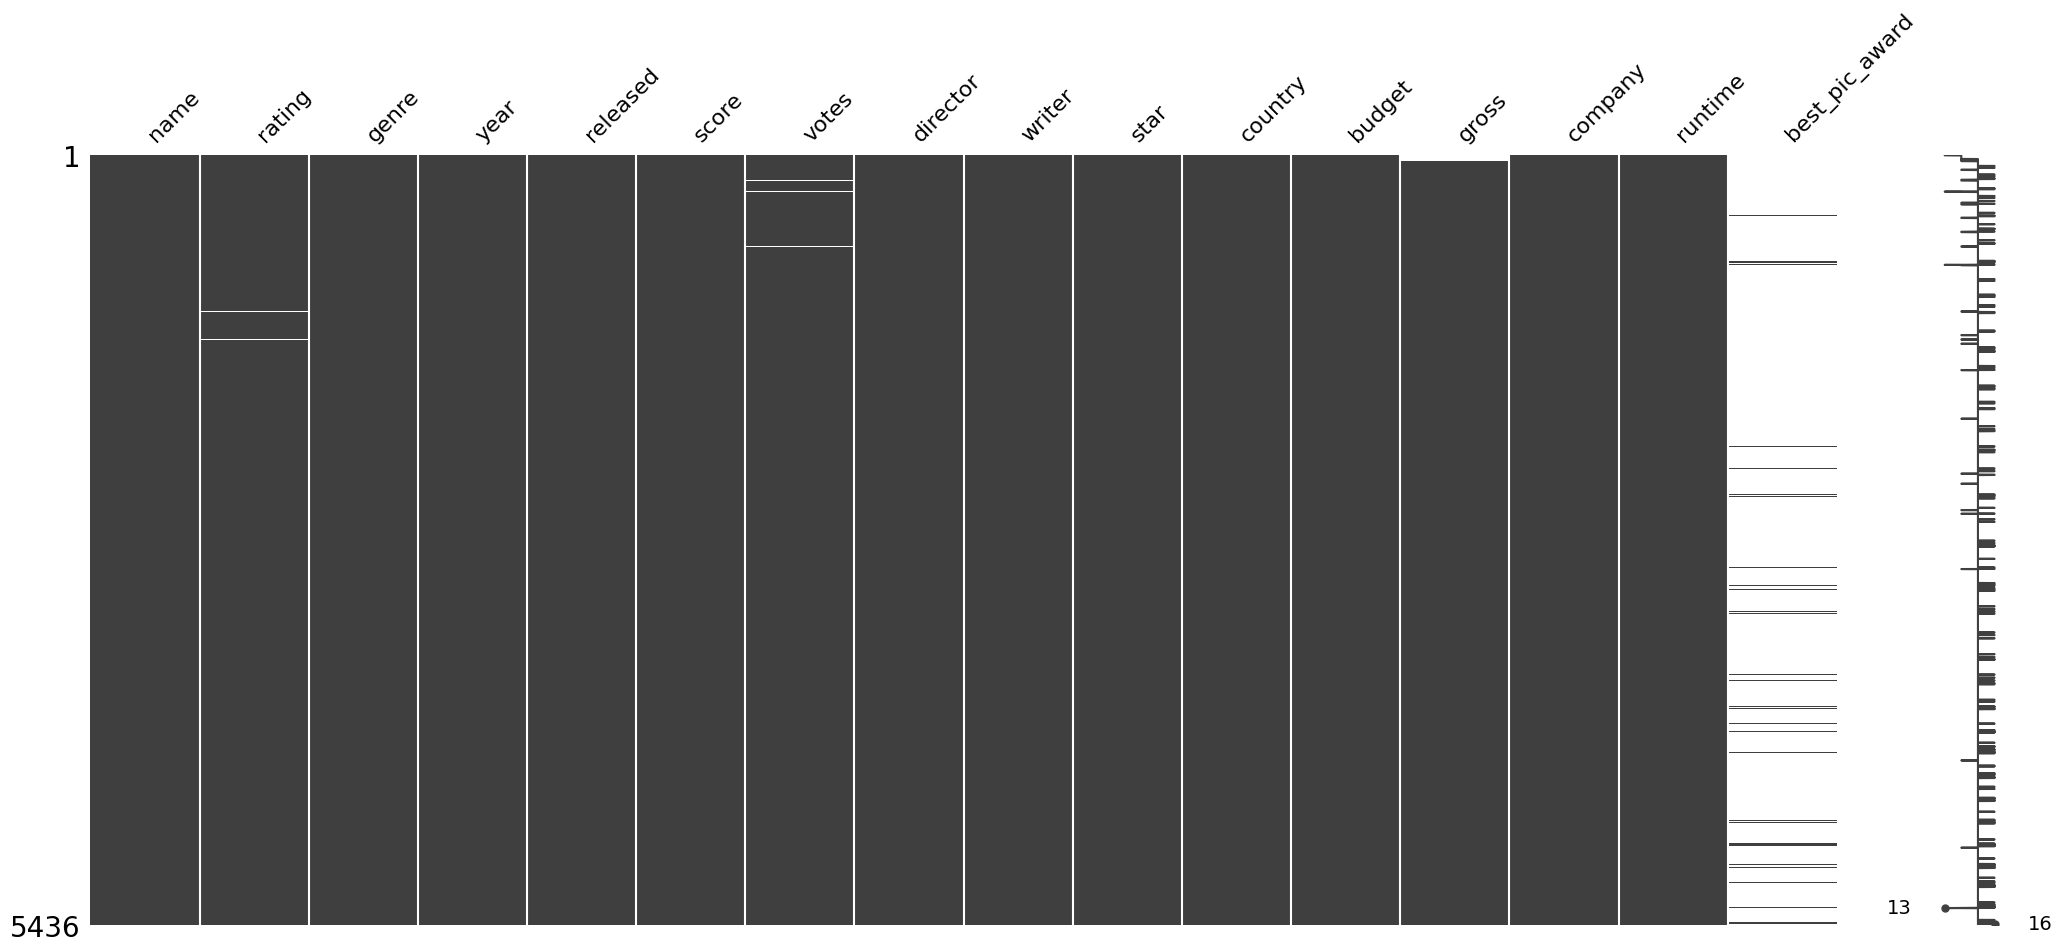

In [32]:
msno.matrix(df)

<Axes: >

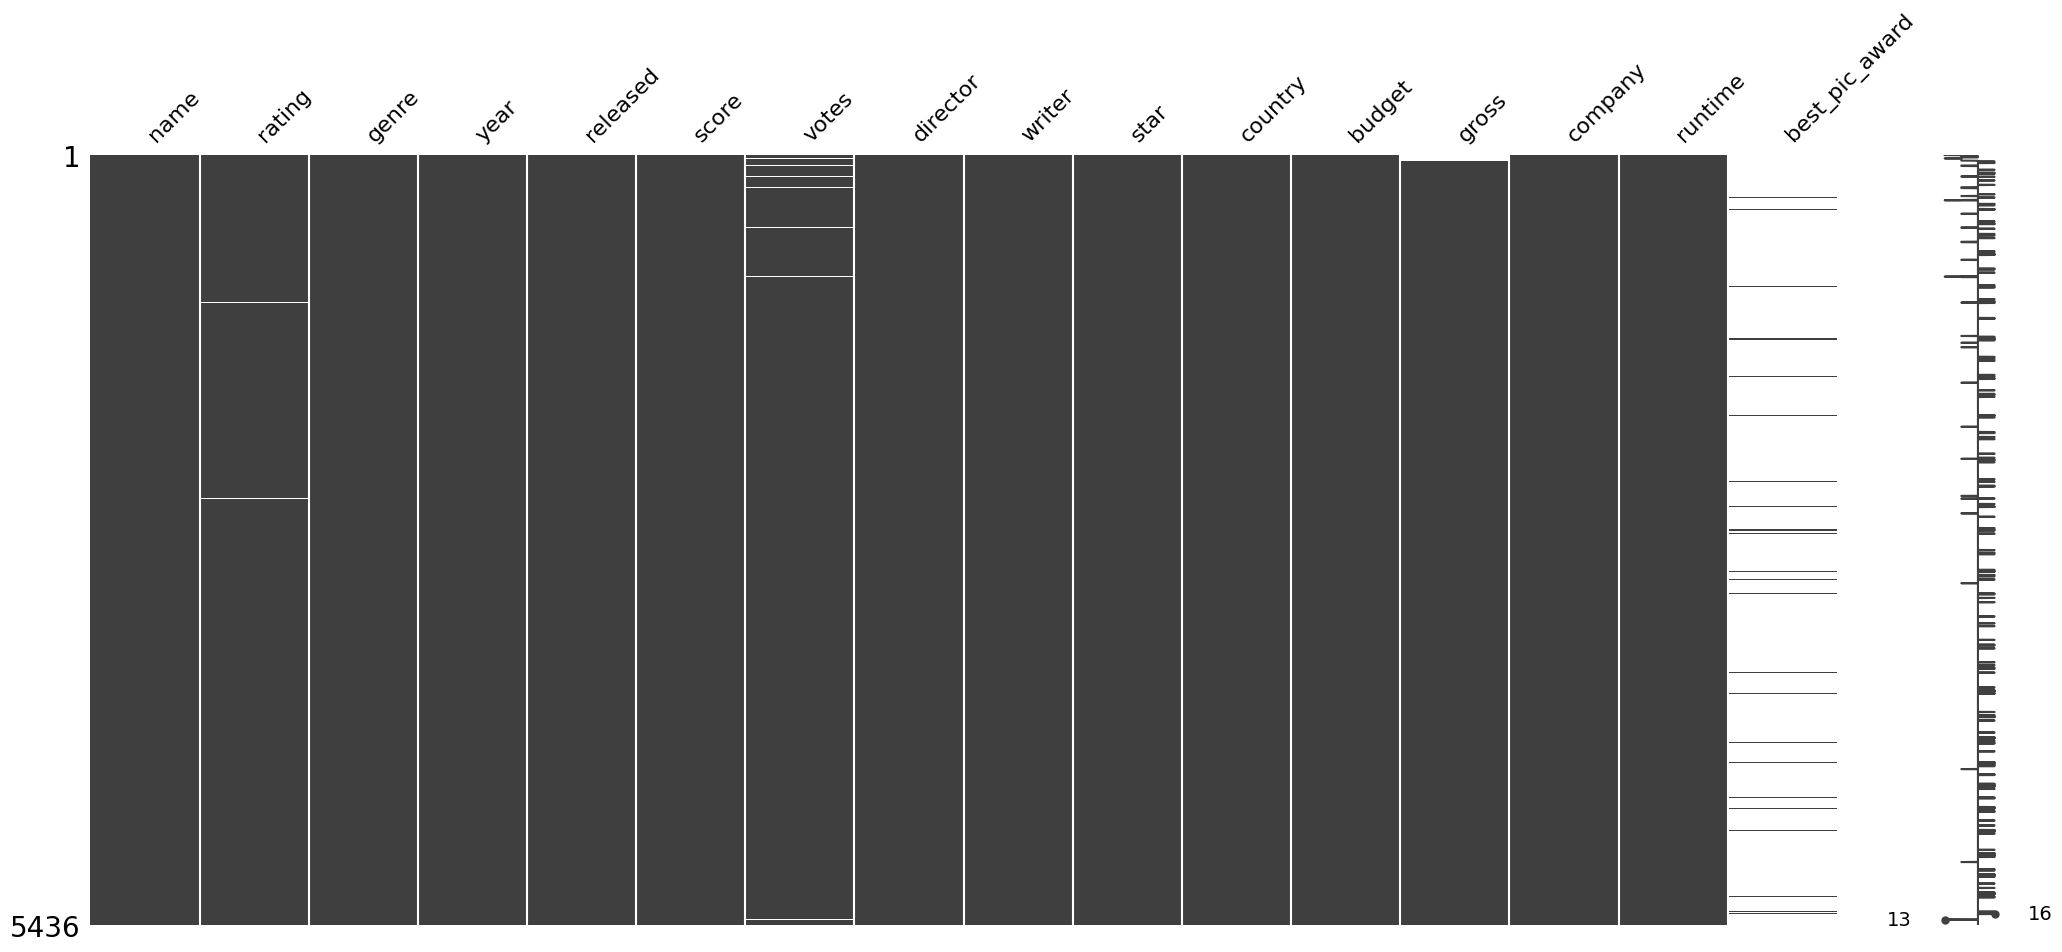

In [33]:
df  = df.sort_values(['year'], ascending=True)
msno.matrix(df)

<Axes: >

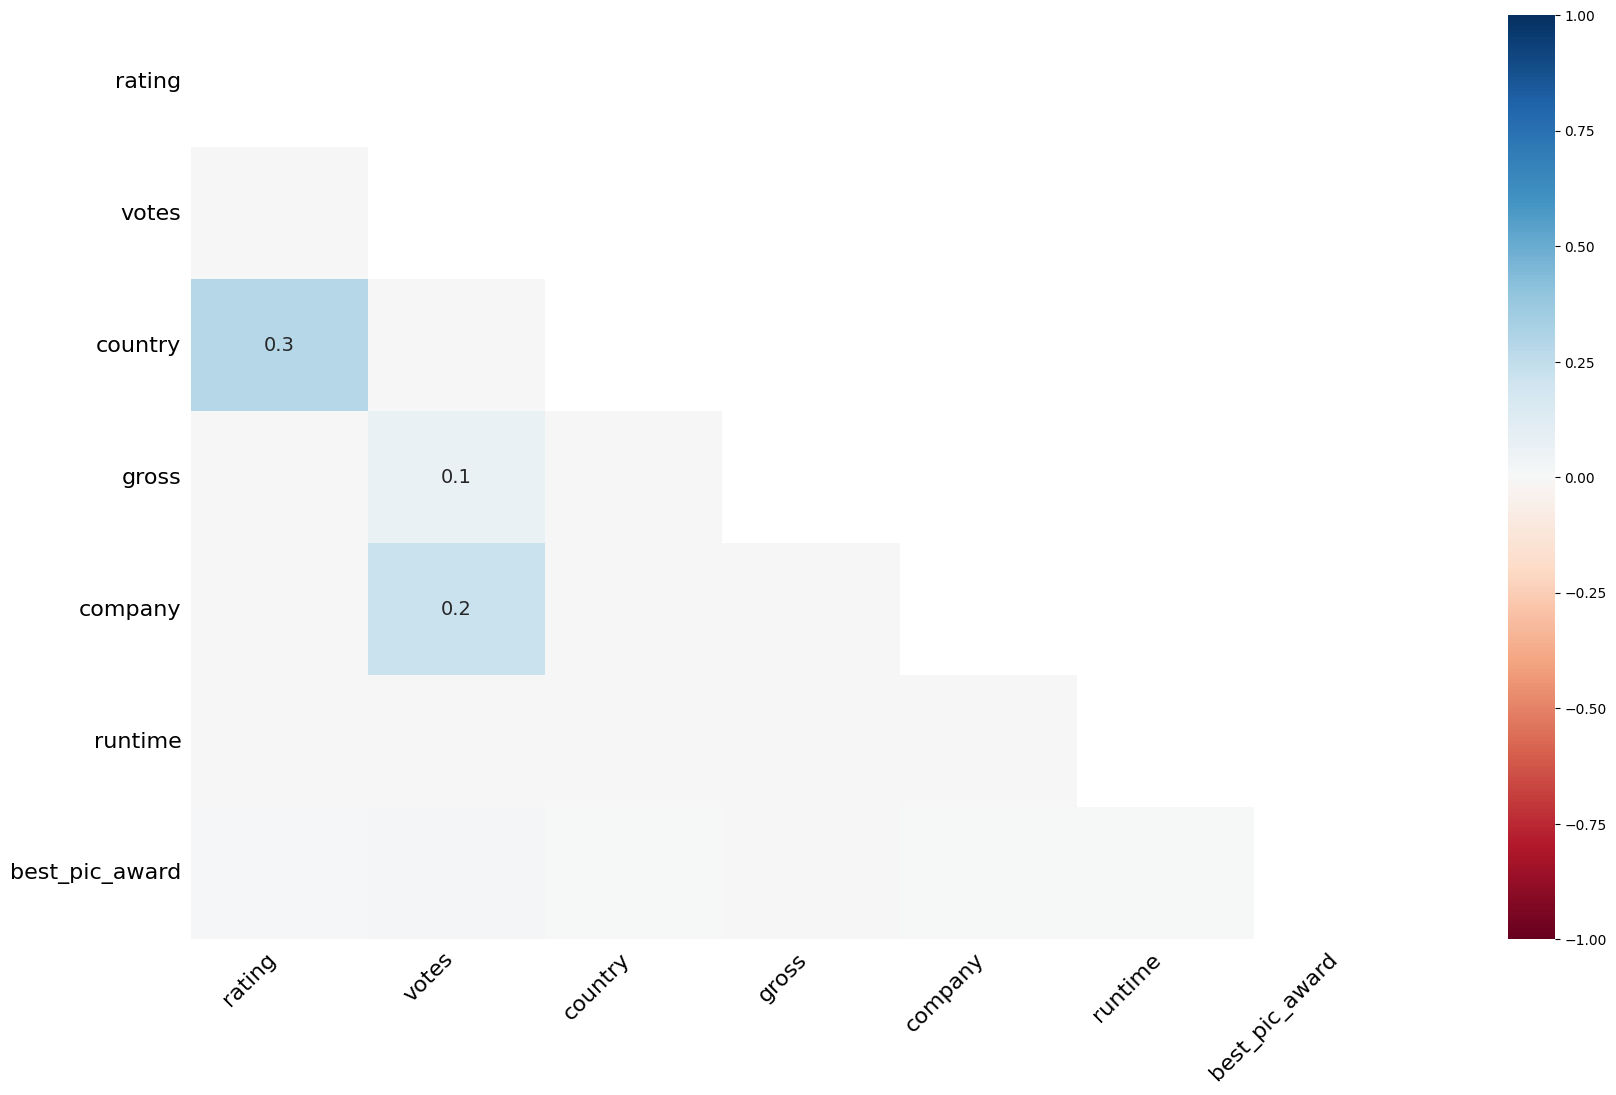

In [34]:
msno.heatmap(df)

Dari Hasil Identifikasi Missing Values didapatkan informasi sebagai berikut:

Kolom yang memiliki missing value

1. `rating`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Mode Imputation**
<br /><br />
2. `votes`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MNAR**
<br />Strategi: **Enrichment**
<br /><br />
3. `country`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Deletion**
<br /><br />
4. `gross`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MAR**
<br />Strategi: **Median Imputation**
<br /><br />
5. `company`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Deletion**
<br /><br />
6. `runtime`
<br />Tipe atribut (Categorical/Numerik): **Numerik**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MCAR**
<br />Strategi: **Enrichment**
<br /><br />
5. `best_pic_award`
<br />Tipe atribut (Categorical/Numerik): **Categorical**
<br />Tipe Missing Values (MCAR/MAR/MNAR): **MAR**
<br />Strategi: **"Missing" Imputation**
<br /><br />

##1.2 Handling Missing Values

###1.2.1 Rating

Kita telah memutuskan bahwa penanganan missing values pada `rating` akan ditempuh menggunakan *mode imputation*

In [35]:
# cari rating dengan frekuensi tertinggi
df.rating.value_counts()

R            2597
PG-13        1730
PG            909
G             111
Not Rated      44
Unrated        17
NC-17          12
TV-MA           2
Approved        1
X               1
Name: rating, dtype: int64

In [51]:
df[~df.rating.isna()].head(3)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,NaN,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
22,American Gigolo,R,Crime,1980,"February 1, 1980 (United States)",6.2,22000.0,Paul Schrader,Paul Schrader,Richard Gere,United States,4800000,NaN,Paramount Pictures,117.0,NaN
23,Private Benjamin,R,Comedy,1980,"October 10, 1980 (United States)",6.2,24000.0,Howard Zieff,Nancy Meyers,Goldie Hawn,United States,10000000,NaN,Warner Bros.,109.0,NaN


In [44]:
# cari genre tertinggi untuk missing values pada kolom rating
df[df.rating.isna()].groupby('genre')['name'].count().sort_values(ascending=False)

genre
Drama        5
Horror       3
Action       1
Animation    1
Crime        1
Fantasy      1
Name: name, dtype: int64

In [45]:
# temukan rating tertinggi untuk kedua genre tersebut
df[df.genre.isin(['Drama','Horror'])]['rating'].value_counts()

R            657
PG-13        335
PG            83
Not Rated     24
NC-17          7
Unrated        4
G              3
X              1
TV-MA          1
Name: rating, dtype: int64

In [260]:
# lakukan imputation dengan men-set nilai missing values pada kolom rating dengan rating tertinggi yang ditemukan sebelumnya
df.rating.fillna("R", inplace=True)

In [261]:
df.isna().sum().rating

0

###1.2.2 Votes

In [72]:
# load data movies_votes yang digunakan pada votes enrichment
df_votes = pd.read_csv("1a. movies_votes.csv")
df_votes.columns = ["votes_"+col for col in list(df_votes.columns )]
df_votes.head()

,votes_name,votes_genre,votes_year,votes_score,votes_votes
0,High on the Hog,Action,2019,3.5,195
1,Getting It on,Comedy,1983,3.7,208
2,Almost You,Comedy,1984,5.1,216
3,Fever Pitch,Drama,1985,4.1,243
4,Sky Bandits,Action,1986,4.6,258


In [262]:
# lakukan join antara df dengan df_votes dengan menggunakan 3 atribut sebagai join key: judul film, tahun rilis, dan imdb score
df_merge = pd.merge(df, df_votes, how='left', left_on=['name','year','score'], right_on=['votes_name','votes_year','votes_score'])
df_merge.head()

,name,rating,genre,year,released,score,votes,director,writer,star,...,budget,gross,company,runtime,best_pic_award,votes_name,votes_genre,votes_year,votes_score,votes_votes
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,NaN,Paul Mazursky,Jean Gruault,Michael Ontkean,...,5500000,NaN,Twentieth Century Fox,115.0,NaN,Willie & Phil,Comedy,1980.0,5.9,415.0
1,Phobia,R,Drama,1980,"September 9, 1980 (United States)",4.0,NaN,John Huston,Gary Sherman,Paul Michael Glaser,...,5100000,NaN,Borough Park Productions,94.0,NaN,Phobia,Drama,1980.0,4.0,546.0
2,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6.1,NaN,Lamont Johnson,David Eyre,Scott Glenn,...,5100000,NaN,Cattle Annie Productions,97.0,NaN,Cattle Annie and Little Britches,Drama,1980.0,6.1,604.0
3,The Last Flight of Noah's Ark,G,Adventure,1980,"June 25, 1980 (United States)",5.8,1300.0,Charles Jarrott,Ernest K. Gann,Elliott Gould,...,6000000,NaN,Walt Disney Productions,97.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Oh Heavenly Dog,PG,Comedy,1980,"July 11, 1980 (United States)",5.4,2400.0,Joe Camp,Rod Browning,Chevy Chase,...,6000000,NaN,Mulberry Square Productions,103.0,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
# baris-baris yang memiliki missing values pada votes, indexnya akan disimpan pada variable `checked_rows`
# ini untuk memudahkan pengecekan apakah proses imputasi sudah dijalankan dengan benar

checked_rows = list(df_merge[df_merge.votes.isna()].index)
df_merge.loc[checked_rows][['name','votes','votes_votes']].head(5)

,name,votes,votes_votes
0,Willie & Phil,NaN,415.0
1,Phobia,NaN,546.0
2,Cattle Annie and Little Britches,NaN,604.0
40,King of the Mountain,NaN,384.0
41,Inchon,NaN,659.0


In [264]:
# lakukan imputasi untuk seluruh missing values pada kolom `votes` menggunakan kolom hasil data enrichment: `votes_votes`
df_merge['votes'] = df_merge.apply(lambda x: x['votes_votes'] if np.isnan(x['votes']) else x['votes'], axis=1)

#sanity check
df_merge.loc[checked_rows][['name','votes','votes_votes']].head(5)

,name,votes,votes_votes
0,Willie & Phil,415.0,415.0
1,Phobia,546.0,546.0
2,Cattle Annie and Little Britches,604.0,604.0
40,King of the Mountain,384.0,384.0
41,Inchon,659.0,659.0


In [265]:
# karena imputasi sudah dilakukan, maka kolom-kolom hasil enrichment tidak dibutuhkan lagi.
df = df_merge[list(df.columns)]

#sanity check
df.loc[checked_rows].head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
0,Willie & Phil,R,Comedy,1980,"August 15, 1980 (United States)",5.9,415.0,Paul Mazursky,Jean Gruault,Michael Ontkean,United States,5500000,NaN,Twentieth Century Fox,115.0,NaN
1,Phobia,R,Drama,1980,"September 9, 1980 (United States)",4.0,546.0,John Huston,Gary Sherman,Paul Michael Glaser,Canada,5100000,NaN,Borough Park Productions,94.0,NaN
2,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6.1,604.0,Lamont Johnson,David Eyre,Scott Glenn,United States,5100000,NaN,Cattle Annie Productions,97.0,NaN
40,King of the Mountain,PG,Action,1981,"May 1, 1981 (United States)",5.5,384.0,Noel Nosseck,David Barry,Harry Hamlin,United States,2000000,1791147.0,PolyGram Pictures,90.0,NaN
41,Inchon,PG,Drama,1981,"September 17, 1982 (United States)",2.7,659.0,Terence Young,Robin Moore,Laurence Olivier,South Korea,46000000,5200986.0,One Way Productions,140.0,NaN


In [266]:
df.votes.isna().sum()

0

###1.2.3. Country

In [118]:
df[df['country'].isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
5396,Clinton Road,R,Horror,2019,"June 14, 2019 (United States)",5.9,1900.0,Richard Grieco,Noel Ashman,Ace Young,NaN,2500000,50400.0,Growing Tree Productions,77.0,NaN


In [267]:
#lakukan deletion pada kolom country
df.dropna(subset=['country'], inplace=True)
df.country.isna().sum()

0

###1.2.4 Runtime

In [120]:
df[df['runtime'].isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
4334,One for the Money,PG-13,Action,2012,"January 27, 2012 (United States)",5.3,41000.0,Julie Anne Robinson,Stacy Sherman,Katherine Heigl,United States,40000000,38084162.0,Lakeshore Entertainment,NaN,NaN


In [268]:
# sedikit googling akan memberikan informasi runtime atas film tersebut yakni: 91 menit
df['runtime'].fillna(91, inplace=True)
df.runtime.isna().sum()

0

###1.2.5 Company

In [122]:
df[df.company.isna()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,best_pic_award
319,The Bear,PG,Biography,1984,"September 28, 1984 (United States)",6.1,270.0,Richard C. Sarafian,Michael Kane,Gary Busey,United States,221000,2687148.0,NaN,110.0,NaN
858,Heart of Dixie,PG,Drama,1989,"August 25, 1989 (United States)",5.2,677.0,Martin Davidson,Anne Rivers Siddons,Ally Sheedy,United States,8000000,1097333.0,NaN,95.0,NaN


In [269]:
#lakukan proses deletion pada atribut company
df.dropna(subset=['company'], inplace=True)
df.company.isna().sum()

0

###1.2.6 Gross

In [270]:
# berikut adalah daftar genre dari setiap record dengan missing values pada atribut gross
df[df['gross'].isna()].groupby(['genre'])['name'].count().sort_values(ascending=False)

genre
Action       11
Comedy       10
Adventure     5
Drama         5
Crime         4
Biography     2
Horror        2
Fantasy       1
Name: name, dtype: int64

In [271]:
# berikut adalah daftar genre dari setiap record dengan missing values pada atribut gross
missing_genres = list(df[df['gross'].isna()].groupby(['genre'])['name'].count().index)
missing_genres

['Action',
 'Adventure',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Fantasy',
 'Horror']

In [272]:
# Asumsi: seluruh missing values akan di-impute dengan menggunakan median untuk masing-masing genre pada 1981
for genre in missing_genres:
  rows_to_impute = (df['genre'] == genre) & (df['gross'].isna())
  median = df[(df['genre'] == genre) & (df['year'] == 1981)].median()['gross']
  checked_rows = list(df.loc[rows_to_impute, :].index)

  print(f"genre: {genre}")
  print(f"median: {median}")

  df.loc[rows_to_impute, 'gross'] = median
  display(df.loc[checked_rows, 'gross'])

  print()

genre: Action
median: 19905359.0


5     19905359.0
6     19905359.0
7     19905359.0
10    19905359.0
11    19905359.0
13    19905359.0
18    19905359.0
20    19905359.0
32    19905359.0
35    19905359.0
39    19905359.0
Name: gross, dtype: float64


genre: Adventure
median: 27966875.5


3     27966875.5
16    27966875.5
26    27966875.5
29    27966875.5
30    27966875.5
Name: gross, dtype: float64


genre: Biography
median: 40382659.0


12    40382659.0
37    40382659.0
Name: gross, dtype: float64


genre: Comedy
median: 26154211.0


0     26154211.0
4     26154211.0
8     26154211.0
9     26154211.0
14    26154211.0
21    26154211.0
23    26154211.0
25    26154211.0
33    26154211.0
36    26154211.0
Name: gross, dtype: float64


genre: Crime
median: 10062128.5


17    10062128.5
19    10062128.5
22    10062128.5
27    10062128.5
Name: gross, dtype: float64


genre: Drama
median: 10011275.0


1     10011275.0
2     10011275.0
24    10011275.0
28    10011275.0
38    10011275.0
Name: gross, dtype: float64


genre: Fantasy
median: nan


15   NaN
Name: gross, dtype: float64


genre: Horror
median: 10626725.0


31    10626725.0
34    10626725.0
Name: gross, dtype: float64

In [273]:
# setelah diteliti ternyata masih terdapat 1 missing value pada atribut gross. Hal ini disebabkan pada proses imputasi sebelumnya,
# record tersebut tidak berhasil diupdate karena pada tahun 1981 tidak terdapat record dengan genre Fantasy.
df[df['genre'] == 'Fantasy'].year.value_counts().sort_index(ascending=True)

1980    1
1982    1
1983    1
1985    2
1987    3
1988    4
1989    2
1990    1
1991    1
1992    2
1993    2
1994    1
1995    2
1996    1
1997    2
1998    1
1999    2
2001    2
2003    1
2006    1
2007    2
2008    1
2010    1
2011    1
2013    1
2018    1
2019    2
Name: year, dtype: int64

In [274]:
# karena jumlah film pada genre Fantasy terbatas, maka proses imputasi akan menggunakan median dari gross film Fantasy pada rentang waktu 1981-1989
condition = (df['genre'] == 'Fantasy') & (df['year'].isin(list(range(1981,1990))))
fantasy_median = df[condition]['gross'].median()
df.loc[(df['genre'] == 'Fantasy') & (df['gross'].isna()), 'gross'] = fantasy_median
df.gross.isna().sum()

0

###1.2.7 Best Picture Award

In [275]:
df.best_pic_award.value_counts(dropna=False)

NaN          5225
nominated     171
winner         37
Name: best_pic_award, dtype: int64

In [276]:
df.best_pic_award.fillna("none", inplace=True)
df.best_pic_award.value_counts(dropna=False)

none         5225
nominated     171
winner         37
Name: best_pic_award, dtype: int64

#2. Further Cleaning and Enrichment

##2.1 Split kolom `released` menjadi kolom `released_date` dan kolom `released_country`

Kali ini kita akan menggunakan regular expression untuk mengambil nilai/teks tertentu pada sebuah kolom (dalam kasus ini kolom `released`) untuk dipetakan ke beberapa kolom baru (dalam kasus ini kolom `released_date` dan `released_country`)

In [277]:
df['released_date'] = df['released'].apply(lambda x: pd.to_datetime(x.split("(")[0].strip()))
df[['name','released','released_date']].head()

,name,released,released_date
0,Willie & Phil,"August 15, 1980 (United States)",1980-08-15
1,Phobia,"September 9, 1980 (United States)",1980-09-09
2,Cattle Annie and Little Britches,"April 24, 1981 (United States)",1981-04-24
3,The Last Flight of Noah's Ark,"June 25, 1980 (United States)",1980-06-25
4,Oh Heavenly Dog,"July 11, 1980 (United States)",1980-07-11


In [278]:
df['released'].apply(lambda x: x.split("(")[1].replace(")","").strip())

0       United States
1       United States
2       United States
3       United States
4       United States
            ...      
5431    United States
5432    United States
5433    United States
5434    United States
5435    United States
Name: released, Length: 5433, dtype: object

In [279]:
df['released_country'] = df['released'].apply(lambda x: re.findall("\((.*?)\)", x)[0])
df[['name','released','released_country']].head()

,name,released,released_country
0,Willie & Phil,"August 15, 1980 (United States)",United States
1,Phobia,"September 9, 1980 (United States)",United States
2,Cattle Annie and Little Britches,"April 24, 1981 (United States)",United States
3,The Last Flight of Noah's Ark,"June 25, 1980 (United States)",United States
4,Oh Heavenly Dog,"July 11, 1980 (United States)",United States


In [280]:
df[['name','released','released_date','released_country']].head()

,name,released,released_date,released_country
0,Willie & Phil,"August 15, 1980 (United States)",1980-08-15,United States
1,Phobia,"September 9, 1980 (United States)",1980-09-09,United States
2,Cattle Annie and Little Britches,"April 24, 1981 (United States)",1981-04-24,United States
3,The Last Flight of Noah's Ark,"June 25, 1980 (United States)",1980-06-25,United States
4,Oh Heavenly Dog,"July 11, 1980 (United States)",1980-07-11,United States


##2.2. Hitung Profit

###2.2.1 Hitung *Unadjusted Gross* (50% dari gross yang belum disesuaikan dengan inflasi)

In [281]:
df['unadjusted_gross'] = df['gross'] * 0.5
df[['gross','unadjusted_gross']].head()

,gross,unadjusted_gross
0,26154211.0,13077105.50
1,10011275.0,5005637.50
2,10011275.0,5005637.50
3,27966875.5,13983437.75
4,26154211.0,13077105.50


###2.2.2 Hitung *Unadjusted Profit* (`unadjusted_gross` - `budget`, belum disesuaikan dengan inflasi)

In [282]:
df['unadjusted_profit'] = df['unadjusted_gross'] - df['budget']
df[['name','year','budget','gross','unadjusted_gross','unadjusted_profit']].sample(5)

,name,year,budget,gross,unadjusted_gross,unadjusted_profit
2636,Heaven,2002,11000000,4247089.0,2123544.5,-8876455.5
3315,We Are Marshall,2006,65000000,43545364.0,21772682.0,-43227318.0
3876,"I Love You, Man",2009,40000000,91980359.0,45990179.5,5990179.5
309,Broadway Danny Rose,1984,8000000,10600497.0,5300248.5,-2699751.5
2501,15 Minutes,2001,60000000,56359980.0,28179990.0,-31820010.0


###2.2.3 Hitung Adjusted Profit menggunakan Data Inflasi (*enrichment*)

In [283]:
df_inflation = pd.read_csv("1b. inflation.csv")
df_inflation.head()

,year,present_equivalent_value
0,1956,11.32
1,1957,10.96
2,1958,10.66
3,1959,10.56
4,1960,10.41


In [ ]:
#proses enrichment dengan menggunakan df_inflasion berdasarkan tahun rilis sebagai join key
df = pd.merge(df, df_inflation, how='left', left_on='year', right_on='year')

In [285]:
df[['name','year','unadjusted_profit','present_equivalent_value']].head()

,name,year,unadjusted_profit,present_equivalent_value
0,Willie & Phil,1980,7577105.50,3.73
1,Phobia,1980,-94362.50,3.73
2,Cattle Annie and Little Britches,1980,-94362.50,3.73
3,The Last Flight of Noah's Ark,1980,7983437.75,3.73
4,Oh Heavenly Dog,1980,7077105.50,3.73


In [286]:
df['adjusted_profit'] = df['unadjusted_profit'] * df['present_equivalent_value']
df[['name','year','budget','gross','unadjusted_gross','unadjusted_profit', 'present_equivalent_value','adjusted_profit']].sample(5)

,name,year,budget,gross,unadjusted_gross,unadjusted_profit,present_equivalent_value,adjusted_profit
2484,The Glass House,2001,30000000,23619609.0,11809804.5,-18190195.5,1.74,-3.165094e+07
4090,Alvin and the Chipmunks: Chipwrecked,2011,75000000,342695435.0,171347717.5,96347717.5,1.37,1.319964e+08
1985,Paulie,1998,23000000,26875268.0,13437634.0,-9562366.0,1.89,-1.807287e+07
2370,The Road to El Dorado,2000,95000000,76432727.0,38216363.5,-56783636.5,1.79,-1.016427e+08
1385,Groundhog Day,1993,14600000,71074049.0,35537024.5,20937024.5,2.13,4.459586e+07


###2.2.4 Kategorisasi Profit

In [287]:
df['adjusted_profit'].describe()

count    5.433000e+03
mean     2.290384e+07
std      1.062095e+08
min     -2.389285e+08
25%     -2.146187e+07
50%     -1.804067e+06
75%      2.922670e+07
max      1.729581e+09
Name: adjusted_profit, dtype: float64

In [288]:
# lakukan kategorisasi adjusted profit berdasarkan bracket/bins yang tertera pada deskripsi di awal project ini.
# labels=['loss', 'low_profit', 'medium_profit', 'high_profit', 'very_high_profit']

df['profit_class'] = pd.cut(df['adjusted_profit'],
       bins=[-np.inf, 0, 500000, 1000000, 100000000, np.inf],
       labels = ['loss', 'low_profit', 'medium_profit', 'high_profit', 'very_high_profit'],
       include_lowest=True)
df[['name','adjusted_profit','profit_class']]

,name,adjusted_profit,profit_class
0,Willie & Phil,2.826260e+07,high_profit
1,Phobia,-3.519721e+05,loss
2,Cattle Annie and Little Britches,-3.519721e+05,loss
3,The Last Flight of Noah's Ark,2.977822e+07,high_profit
4,Oh Heavenly Dog,2.639760e+07,high_profit
...,...,...,...
5428,Sonic the Hedgehog,8.908083e+07,high_profit
5429,Bad Boys for Life,1.466706e+08,very_high_profit
5430,The Invisible Man,7.684484e+07,high_profit
5431,Birds of Prey,1.955078e+07,high_profit


In [289]:
selected_cols = ['name','rating','genre','year','released_date','score',
                 'director','budget','unadjusted_gross','unadjusted_profit','adjusted_profit','profit_class']
df = df[selected_cols]
df.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,high_profit
1,Phobia,R,Drama,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,-3.519721e+05,loss
2,Cattle Annie and Little Britches,PG,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,-3.519721e+05,loss
3,The Last Flight of Noah's Ark,G,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,2.977822e+07,high_profit
4,Oh Heavenly Dog,PG,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,2.639760e+07,high_profit


#3. Verifying

Pada tahapan Verifikasi, kita akan memastikan bahwa data saat ini sudah konsisten dan memenuhi aturan bisnis yang berlaku. Ada dua aturan bisnis yang akan kita verifikasi yaitu:

1.  Kolom `year` harus terisi nilai dalam interval 1980 s.d. 2020
2.  Kolom `budget` harus berisi nilai lebih dari 0

In [290]:
# verifikasi menggunakan pandera
schema = pa.DataFrameSchema(
    {
        "year": pa.Column(int, pa.Check.isin(list(range(1980,2023)))),
        "budget": pa.Column(int, pa.Check.greater_than(0))
    }
)
schema.validate(df)

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,1.307711e+07,7.577106e+06,2.826260e+07,high_profit
1,Phobia,R,Drama,1980,1980-09-09,4.0,John Huston,5100000,5.005638e+06,-9.436250e+04,-3.519721e+05,loss
2,Cattle Annie and Little Britches,PG,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5.005638e+06,-9.436250e+04,-3.519721e+05,loss
3,The Last Flight of Noah's Ark,G,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,1.398344e+07,7.983438e+06,2.977822e+07,high_profit
4,Oh Heavenly Dog,PG,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,1.307711e+07,7.077106e+06,2.639760e+07,high_profit
...,...,...,...,...,...,...,...,...,...,...,...,...
5428,Sonic the Hedgehog,PG,Action,2020,2020-02-14,6.5,Jeff Fowler,85000000,1.598578e+08,7.485784e+07,8.908083e+07,high_profit
5429,Bad Boys for Life,R,Action,2020,2020-01-17,6.6,Adil El Arbi,90000000,2.132526e+08,1.232526e+08,1.466706e+08,very_high_profit
5430,The Invisible Man,R,Drama,2020,2020-02-28,7.1,Leigh Whannell,7000000,7.157550e+07,6.457550e+07,7.684484e+07,high_profit
5431,Birds of Prey,R,Action,2020,2020-02-07,6.1,Cathy Yan,84500000,1.009292e+08,1.642923e+07,1.955078e+07,high_profit


In [292]:
# verifikasi menggunakan .describe()
df[['year','budget']].describe()

,year,budget
count,5433.000000,5.433000e+03
mean,2001.653967,3.595651e+07
std,10.537955,4.155214e+07
min,1980.000000,6.000000e+03
25%,1993.000000,1.000000e+07
50%,2002.000000,2.100000e+07
75%,2011.000000,4.500000e+07
max,2020.000000,3.560000e+08


#4. Publishing

Mengingat stakeholder kita adalah Data Analyst dan Data Scientist, maka hasil data wrangling akan disesuaikan dengan kebutuhan masing-masing stakeholder.

*  Data Analyst : EDA, Analisis Lebih Lanjut
*  Data Scientist: Pengembangan Model Prediktif

In [293]:
df_for_analyst = df.copy()
df_for_datsci = df.copy()

print("Number of Records for Dat Analyst: ", len(df_for_analyst))
print("Number of Records for Data Scientist: ", len(df_for_datsci))

Number of Records for Dat Analyst:  5433
Number of Records for Data Scientist:  5433


##4.1 For Data Analyst

In [294]:
df_for_analyst.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,high_profit
1,Phobia,R,Drama,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,-3.519721e+05,loss
2,Cattle Annie and Little Britches,PG,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,-3.519721e+05,loss
3,The Last Flight of Noah's Ark,G,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,2.977822e+07,high_profit
4,Oh Heavenly Dog,PG,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,2.639760e+07,high_profit


Kelompokkan data berdasarkan *profit_class* dan bandingkan jumlah film yang dikategorikan ke dalam masing-masing kategori pada *profit_class*. Buatlah sebuah visualisasi atas perbandingan tersebut!

<Axes: xlabel='profit_class'>

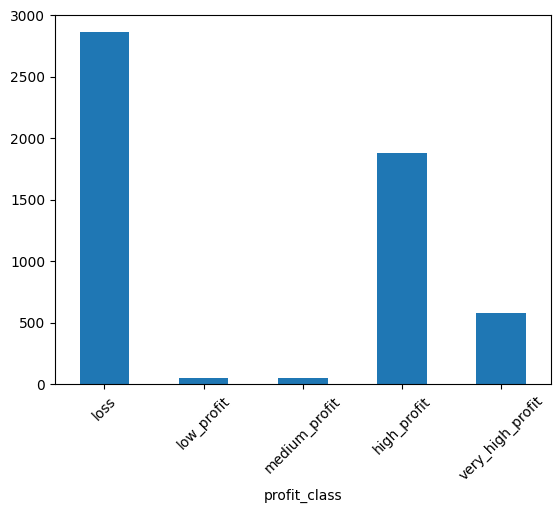

In [299]:
df_for_analyst.groupby(['profit_class'])['name'].count().plot.bar(rot=45)

korelasi antara imdb score dengan adjusted profit. Apakah tingginya *tingginya imdb score* berkorelasi dengan nilai *adjusted profit*?

In [303]:
df_for_analyst[['score','adjusted_profit']].corr()

,score,adjusted_profit
score,1.000000,0.276005
adjusted_profit,0.276005,1.000000


Ekspor data final ke dalam sebuah file .csv

In [ ]:
df_for_analyst.to_csv("movies_clean.csv", index=False)

##4.2 For Data Scientist

Metode encoding apa yang tepat untuk *profit_class*? One-Hot Encoding atau Label Encoding?

In [304]:
profit2class = {c:i for i,c in enumerate(df_for_datsci['profit_class'].dtype.categories.to_list())}
profit2class

{'loss': 0,
 'low_profit': 1,
 'medium_profit': 2,
 'high_profit': 3,
 'very_high_profit': 4}

In [305]:
df_for_datsci['profit_class'] = df_for_datsci['profit_class'].apply(lambda x: profit2class.get(x))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,R,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,Phobia,R,Drama,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,-3.519721e+05,0
2,Cattle Annie and Little Britches,PG,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,-3.519721e+05,0
3,The Last Flight of Noah's Ark,G,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,2.977822e+07,3
4,Oh Heavenly Dog,PG,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,2.639760e+07,3


Metode encoding apa yang tepat untuk *rating*? One-Hot Encoding atau Label Encoding?

In [306]:
rating_hierarchy = ['Approved','G','PG','PG-13','R','NC-17','X','TV-MA','Not Rated','Unrated']

rating2class = {r:i for i, r in enumerate(rating_hierarchy)}

df_for_datsci['rating'] = df_for_datsci['rating'].apply(lambda x: rating2class.get(x))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,4,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,Phobia,4,Drama,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,-3.519721e+05,0
2,Cattle Annie and Little Britches,2,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,-3.519721e+05,0
3,The Last Flight of Noah's Ark,1,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,2.977822e+07,3
4,Oh Heavenly Dog,2,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,2.639760e+07,3


Metode encoding apa yang tepat untuk *genre*? One-Hot Encoding atau Label Encoding?

In [307]:
df_for_datsci = df_for_datsci.join(pd.get_dummies(df['genre'], 'genre'))
df_for_datsci.head()

,name,rating,genre,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,...,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_Western
0,Willie & Phil,4,Comedy,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,...,0,0,0,0,0,0,0,0,0,0
1,Phobia,4,Drama,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,...,0,1,0,0,0,0,0,0,0,0
2,Cattle Annie and Little Britches,2,Drama,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,...,0,1,0,0,0,0,0,0,0,0
3,The Last Flight of Noah's Ark,1,Adventure,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,...,0,0,0,0,0,0,0,0,0,0
4,Oh Heavenly Dog,2,Comedy,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,...,0,0,0,0,0,0,0,0,0,0


In [309]:
columns  = list(df_for_datsci.columns)

In [310]:
genre_cols = [c for c in columns if c.startswith("genre_")]

In [311]:
new_cols = columns[:2] + genre_cols + columns[3:12]
df_for_datsci = df_for_datsci[new_cols]
df_for_datsci.head()

,name,rating,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,...,genre_Western,year,released_date,score,director,budget,unadjusted_gross,unadjusted_profit,adjusted_profit,profit_class
0,Willie & Phil,4,0,0,0,0,1,0,0,0,...,0,1980,1980-08-15,5.9,Paul Mazursky,5500000,13077105.50,7577105.50,2.826260e+07,3
1,Phobia,4,0,0,0,0,0,0,1,0,...,0,1980,1980-09-09,4.0,John Huston,5100000,5005637.50,-94362.50,-3.519721e+05,0
2,Cattle Annie and Little Britches,2,0,0,0,0,0,0,1,0,...,0,1980,1981-04-24,6.1,Lamont Johnson,5100000,5005637.50,-94362.50,-3.519721e+05,0
3,The Last Flight of Noah's Ark,1,0,1,0,0,0,0,0,0,...,0,1980,1980-06-25,5.8,Charles Jarrott,6000000,13983437.75,7983437.75,2.977822e+07,3
4,Oh Heavenly Dog,2,0,0,0,0,1,0,0,0,...,0,1980,1980-07-11,5.4,Joe Camp,6000000,13077105.50,7077105.50,2.639760e+07,3


Ekspor data final untuk data scientist ke sebuah .csv file

In [312]:
df_for_datsci.to_csv("movies_clean_for_datsci.csv", index=False)